In [9]:
Preparation to match Scapy.

import pandas as pd
import pickle
import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print(f"Scikit-learn version: {sklearn.__version__}")

# Load data with correct headers
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty_level"
]

train_df = pd.read_csv('Train.txt', delimiter=',', header=None, names=column_names)
test_df = pd.read_csv('Test.txt', delimiter=',', header=None, names=column_names)

# Function to convert dataset flags to Scapy-compatible flags
def convert_flag_to_scapy(flag):
    flag_translation = {
        'REJ': 'R',
        'SF': 'PA',
        'S0': 'S',
        'RSTO': 'R',
        'S1': 'S',
        'S2': 'S',
        'S3': 'S',
        'RSTOS0': 'R',
        'OTH': ''
    }
    return ''.join([flag_translation.get(f, '') for f in flag])

# Apply the flag conversion to the 'flag' column
train_df['flag'] = train_df['flag'].apply(convert_flag_to_scapy)
test_df['flag'] = test_df['flag'].apply(convert_flag_to_scapy)

# Convert the multi-class labels into binary labels: 1 for any attack, 0 for normal
train_df['binary_label'] = (train_df['label'] != 'normal').astype(int)
test_df['binary_label'] = (test_df['label'] != 'normal').astype(int)

# Selecting only the necessary features
features_to_use = ['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes']
categorical_features = ['protocol_type', 'service', 'flag']
numerical_features = ['src_bytes', 'dst_bytes']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'  # This drops the columns that are not explicitly transformed
)

# Apply preprocessing to both training and testing data
X_train = preprocessor.fit_transform(train_df[features_to_use])
X_test = preprocessor.transform(test_df[features_to_use])

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Labels for training and testing
y_train = train_df['binary_label']
y_test = test_df['binary_label']

# Create and train a RandomForest classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Scikit-learn version: 1.3.2
Accuracy: 0.8224804826117814


In [10]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Save the model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

# Predict on the training and test set
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Training and Testing Accuracy
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy: ", accuracy_score(y_test, y_test_pred))

Training Accuracy:  0.9491240186389147
Testing Accuracy:  0.8224804826117814


              precision    recall  f1-score   support

           0       0.74      0.89      0.81      9711
           1       0.91      0.77      0.83     12833

    accuracy                           0.82     22544
   macro avg       0.83      0.83      0.82     22544
weighted avg       0.84      0.82      0.82     22544

ROC AUC Score:  0.9248539753605289


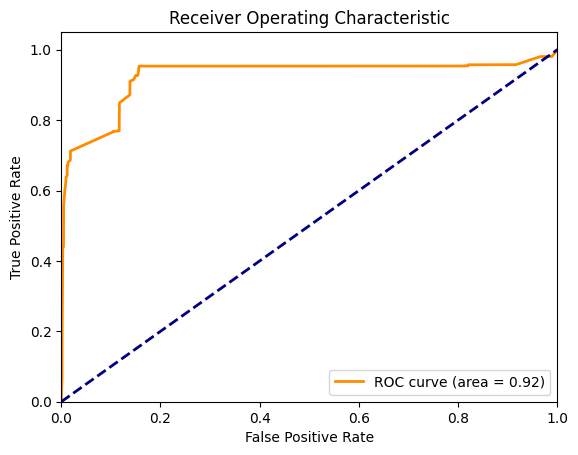

<Figure size 640x480 with 0 Axes>

In [12]:
# Classification Report
print(classification_report(y_test, y_test_pred))

# ROC AUC Score
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

print("ROC AUC Score: ", roc_auc)

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig('rf-roc-curve.eps', format='eps')


Total samples: 22544
Accuracy: 0.8225501113585746


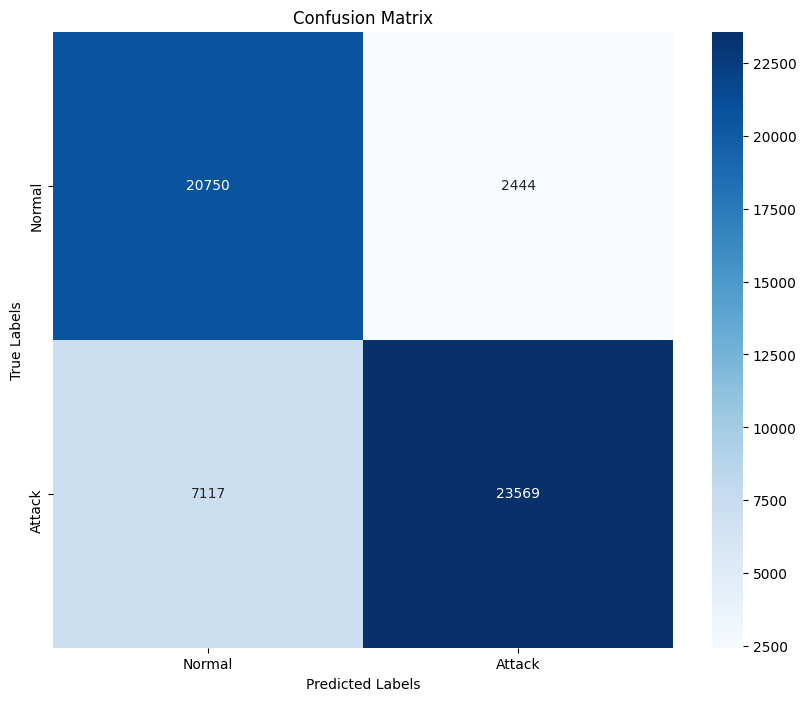

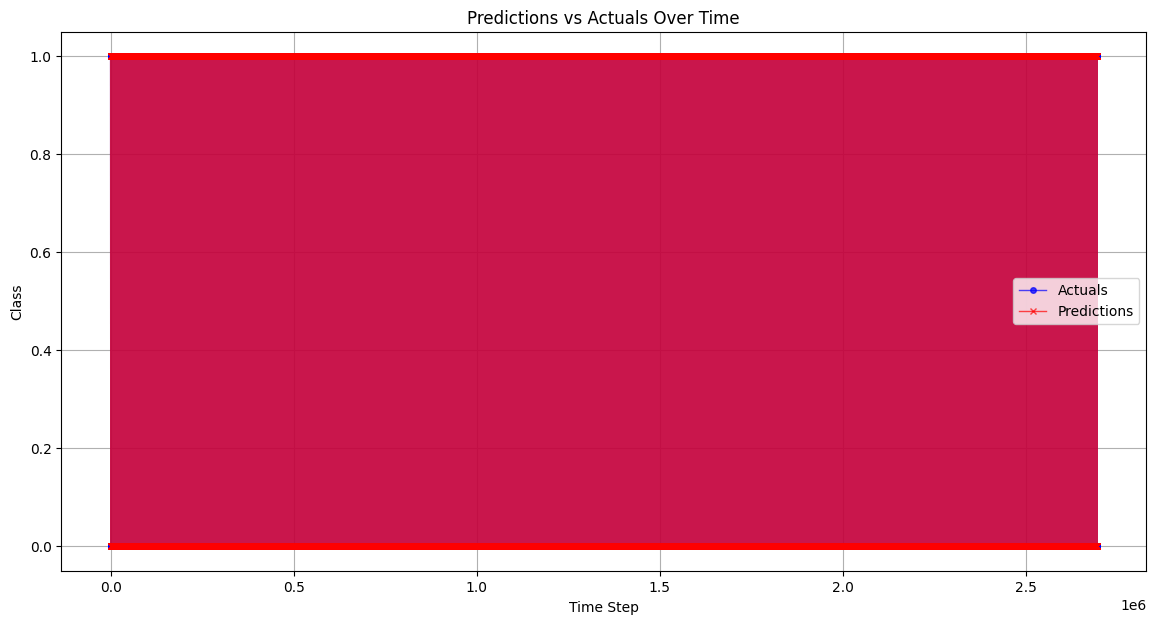

<Figure size 640x480 with 0 Axes>

In [7]:
def sliding_window_prediction(X, y, model, window_size, step_size):
    predictions = []
    actuals = []
    
    num_samples = X.shape[0]
    print("Total samples:", num_samples)
    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window = X[start:end]
        preds = model.predict(window)
        predictions.extend(preds)
        actuals.extend(y[start:end])
        
        # Debug output
        #print(f"Window {start}:{end} - Predictions: {preds[:5]} Actuals: {y[start:end][:5]}")
    
    return np.array(predictions), np.array(actuals)

# Adjust the window and step sizes to test the changes
window_size = 120  # Example change
step_size = 50    # Example change


# Perform the predictions
predictions, actuals = sliding_window_prediction(X_test, y_test, rf_classifier, window_size, step_size)

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)
print(f"Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()






